Let's do a simple greenscreen replacement with a machine-learning model.

We will:
- download and display an image
- pre-process the pixels, labeling background and foreground pixels
- train a model to identify green background pixels
- use the predictions of the model swap the green screen background for an image of a forest

In [22]:
!wget https://github.com/mlittmancs/great_courses_ml/raw/master/imgs/greenML.png

--2023-09-09 21:52:08--  https://github.com/mlittmancs/great_courses_ml/raw/master/imgs/greenML.png
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/imgs/greenML.png [following]
--2023-09-09 21:52:08--  https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/imgs/greenML.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1190198 (1.1M) [image/png]
Saving to: ‘greenML.png.2’

greenML.png.2       100%[===================>]   1.13M  --.-KB/s    in 0.06s   

2023-09-09 21:52:08 (18.1 MB/s) - ‘greenML.png.2’ saved [1190198/1190198]



Here we download and display the image.

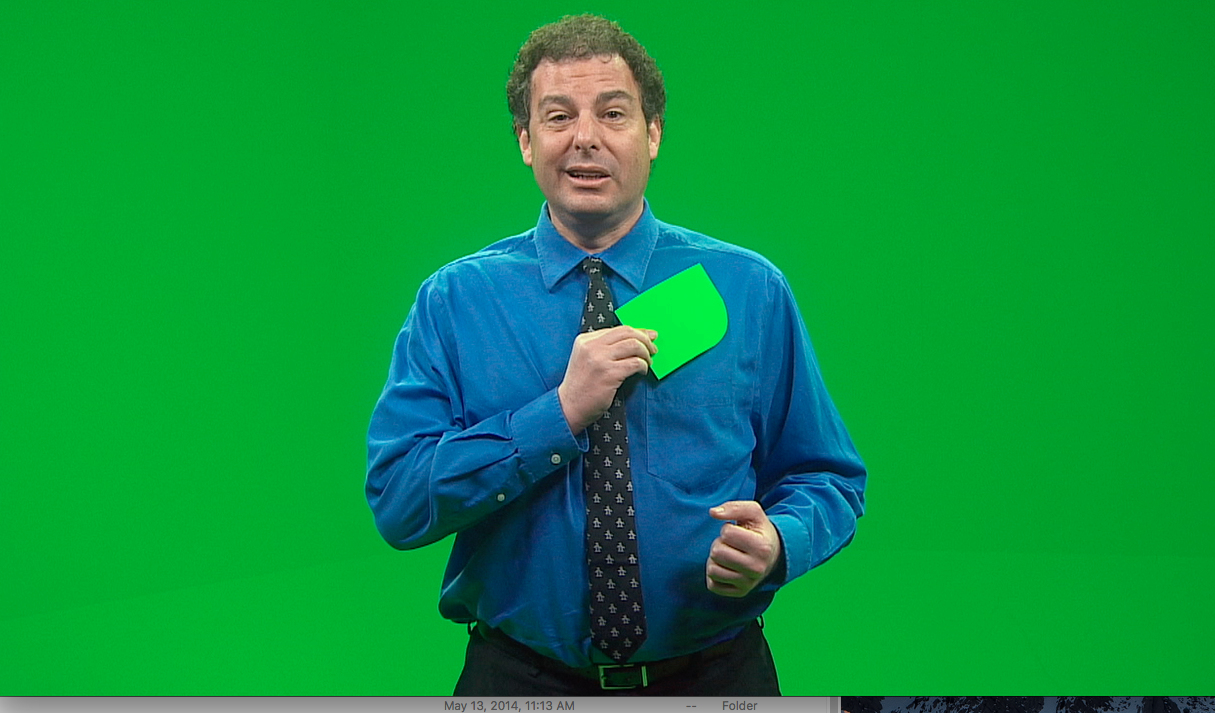

In [23]:
import numpy as np
from tensorflow import keras

img = keras.utils.load_img("greenML.png")

display(img)

Below we trim the edges of the image.

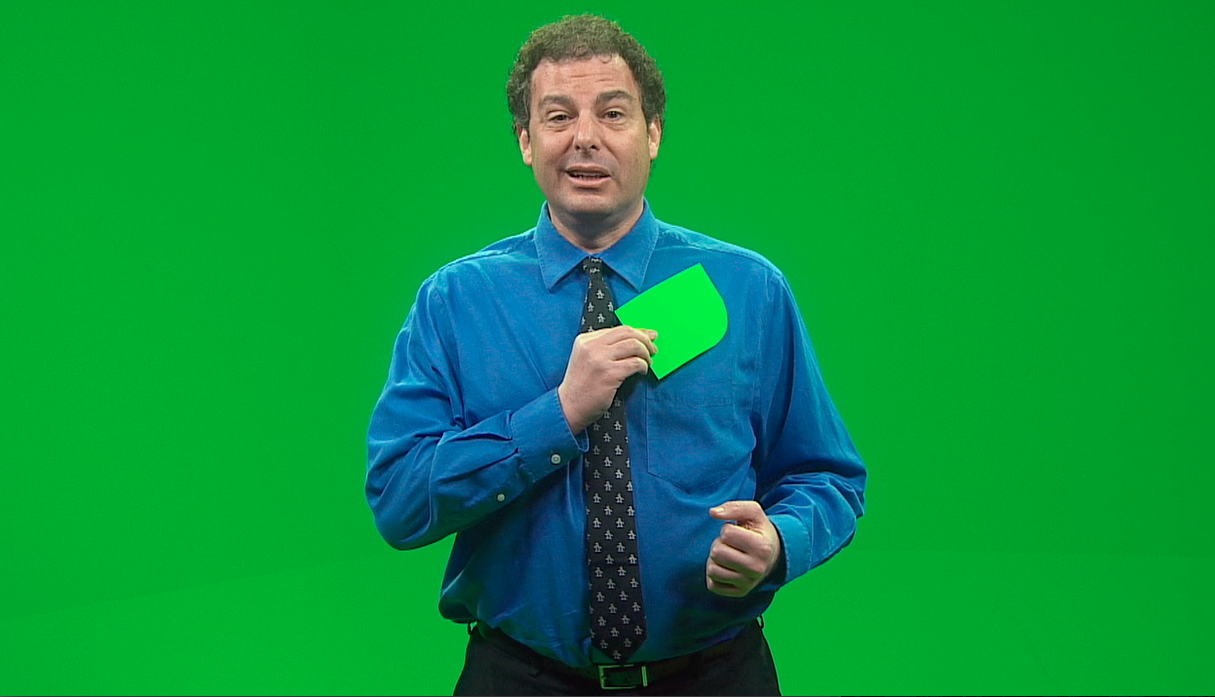

In [24]:
arr = image.img_to_array(img)
# Trim off edges
arr = arr[:697,:]
display(image.array_to_img(arr,scale=False))

In this example, we isolate out the bacground and convert it to a dataset of positive examples, `yesList`.

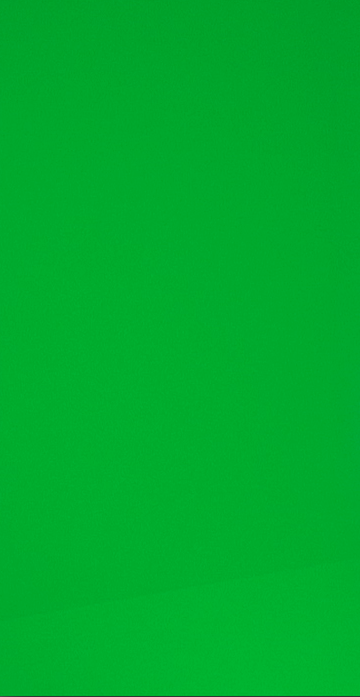

In [25]:
# background
tmp = arr[:,:360]
display(image.array_to_img(tmp,scale=False))

yesList = np.reshape(tmp,(-1,3))

Below we print the number of values in each dimension of `tmp`.

In [26]:
tmp.shape

(697, 360, 3)

Below we print the number of values in each dimension of `yesList`.

In [27]:
yesList.shape

(250920, 3)

Below we build `seen` dictionary of the unique pixel colors in `yesList`.  For all keys in the dictionary, the value is 1.

In [28]:
seen = {}
for c in yesList:
  col = str(c)
  if col not in seen: seen[col] = 1
len(seen)

306

Now we'll isolate out the foreground and make a dataset of foreground pixels called `noList`.

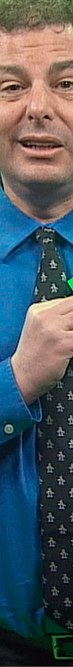

In [29]:
# foreground
tmp = arr[30:,547:620]
display(image.array_to_img(tmp,scale=False))

noList = np.reshape(tmp,(-1,3))

Below is the number of values in each dimension of the full image, corresponding to the height, width, and RGB (red, green, blue) colors.

In [30]:
arr.shape

(697, 1215, 3)

We finalize our dataset here, with a variable `alldat` which cointains our list of pixels, and `labs` which is our list of labels for each pixel, `0` for green background pixels and `1` for foreground pixels

In [31]:
# Build a list of pixels for both positive and negative examples.
alldat = np.concatenate((yesList,noList))

# labels
labs = np.concatenate((np.ones(len(yesList)), np.zeros(len(noList))))

Here, we'll build a classifier to separate the background from the foreground

We define a `loss` function.  The `loss` takes in our data, `alldat`, our labels `labs`, and our current weights, `w`.  We will make adjustments to `w` based on this loss function.  To make a prediction, we will multiply `w` by `alldat`, and pass it through a sigmoid function to get our predictions, `y`.  We will then compare our predictions `y` to their true labels `labs` using a squared loss, the sum of the squared difference between `labs`, our true labels, and `y` our predicted values

In [32]:
# Add an additional column to the data corresponding to
#  the offset parameter.
alldat = np.concatenate((alldat,np.ones((len(alldat),1))),1)

# Compute the loss of the rule specified by weights w with respect
#  to the data alldat labeled with labs
def loss(w, alldat, labs):
  # Compute a weighted sum for each instance
  h = np.matmul(alldat,w)
  # transform the sum using the sigmoid function
  y = 1/(1 + np.exp(-h))
  # take the difference between the labels and the output of the
  #  sigmoid, squared, then sum up over all instances to get the
  #  total loss.
  loss = np.sum((labs - y)**2)
  return(loss)

To see how our `loss` function works, we'll print ou the loss of 10 random sets of weights

In [33]:
# repeat 10 times
for i in range(10):
  # pick a random vector of weights, with values between -1 and 1
  w = np.random.random(4)*2-1
  # report the loss
  print(w, loss(w, alldat, labs))

[ 0.65949641  0.99080674 -0.7195391   0.44299409] 37543.52773796106
[0.23299027 0.80396158 0.74186081 0.46188466] 48684.10092874314
[ 0.51061759  0.65809334  0.92470288 -0.70912491] 48677.37297980186
[ 0.57600488 -0.97508616 -0.10547147 -0.75539813] 251084.56820280632
[ 0.37941033 -0.02382628  0.04178577 -0.78092776] 271248.2309517997
[ 0.88907996  0.13691882 -0.94334062 -0.67500552] 271096.4473554547
[ 0.07221984  0.24233368 -0.21871173  0.57336387] 30476.05234692867
[ 0.54972186  0.16849043 -0.29656187 -0.40889791] 31631.248484416676
[-0.46696522  0.919939    0.73471244 -0.43129118] 48612.11379188869
[ 0.93990991 -0.35126291 -0.25618219 -0.17473255] 278374.12456862384


Now we'll train the model, by creating a `fit` function to fit the model to the data.  We will update the weights through gradient descent.

In [34]:
def fit(w,alldat,labs):
  # alpha represents how big of a step we’ll
  #  be taking in the direction of the derivative.
  #  It’s called the learning rate.
  alpha = 0.1

  # We'll stop searching when we're at a (near) local min
  done = False
  while not done:
    # Every 100 iterations or so, let’s
    #  take a peek at the weights, the learning
    #  rate, and the current loss
    if np.random.random() < 0.01: print(w, alpha, loss(w,alldat,labs))
    # The next few lines compute the gradient
    #  of the loss function. The details aren’t
    #  important right now.
    # delta_w is the change in the weights
    #  suggested by the gradient
    h = np.matmul(alldat,w)
    y = 1/(1 + np.exp(-h))
#    delta_w = np.add.reduce(np.reshape((labs-y) * np.exp(-h)/(1 + np.exp(-h))**2,(len(y),1)) * alldat)
    delta_w = np.add.reduce(np.reshape((labs-y) * np.exp(-h)*y**2,(len(y),1)) * alldat)
    # if we take a step of size alpha and update
    #  the weights, we’ll get new weights neww.
    current_loss = loss(w,alldat,labs)
    alpha *= 2
    neww = w + alpha* delta_w
    while loss(neww,alldat,labs) >= current_loss and not done:
      alpha /= 2
      if alpha*max(abs(delta_w)) < 0.0001:
        done = True
        print(alpha,delta_w)
      else: neww = w + alpha* delta_w
    if not done: w = neww
  return(w)

# w = fit([-2.0, 0, 0.093, -0.713],alldat,labs)

w = [ 0.786,  0.175, -0.558, -0.437]
w = fit(w,alldat,labs)


<ipython-input-32-43a48f8a219c>:11: RuntimeWarning: overflow encountered in exp
  y = 1/(1 + np.exp(-h))


[ 0.55447652  0.23905401 -0.76896451 -0.44458746] 7.62939453125e-07 20313.294085810074
[ 0.0998513   0.30011541 -0.93120046 -0.45123707] 2.44140625e-05 632.5474317197283
[-0.10214474  0.30975624 -0.91354615 -0.46991165] 2.44140625e-05 497.51054838936045
[-0.16425106  0.30195373 -0.88978679 -0.48790009] 2.44140625e-05 489.05701729607125
[-0.31264794  0.26313913 -0.76872967 -0.56756556] 2.44140625e-05 473.4712703744929
[-0.32140851  0.25963747 -0.75907401 -0.57324619] 2.44140625e-05 472.3986829439587
[-0.3315528   0.25478892 -0.74772897 -0.57994421] 2.44140625e-05 471.1531668670855
[-0.4899854   0.18101595 -0.51339805 -0.70704329] 2.44140625e-05 448.52663581384434
[-0.51604406  0.16716788 -0.47088595 -0.73507929] 1.220703125e-05 444.9236954641871
[-0.52309384  0.16395432 -0.4596179  -0.74327471] 1.220703125e-05 444.002941671416
[-0.53217916  0.16033602 -0.44527476 -0.75425477] 1.220703125e-05 442.87106903521476
[-0.54332071  0.15558157 -0.42829586 -0.76840384] 1.220703125e-05 441.5694405

We'll now print the final `loss`

In [35]:
print(loss([-0.138, -1.62, -1.00, -1.00], alldat, labs))
print(loss(w, alldat, labs))


250920.1982577528
404.38377479332183


These are the weights of our learned classifier

In [36]:
w

array([-0.92401732,  0.11230931, -0.2471592 , -2.05978468])

Now we'll display the predictions of the classifier for each pixel in our image.  We reshape our image, `arr` and multiply it by our learned weights, `w` to get our predictions for each pixel belonging to the background, `out`.  We convert `out` into a binary array and reshape to display as an image; `newarr` is our binarized prediction image.

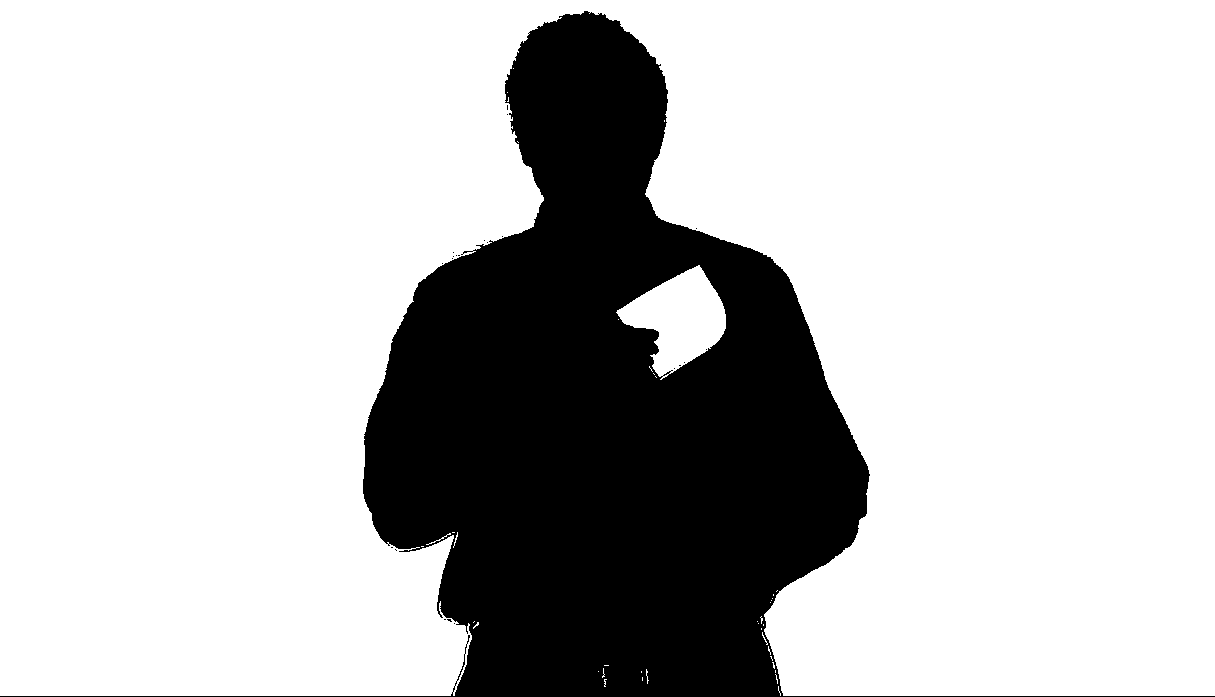

In [37]:
# Turn the pixels in the image into a list
flat = np.reshape(arr,(-1,3))
# Stick a "1" at the end of each color
flat = np.concatenate((flat,np.ones((len(flat),1))),1)
# Multiply by the pixels by the weight matrix,
#  and set a threshold of 0.
out = np.matmul(flat, w) > 0.0
# Reshape the output as a 2 dimensional list instead of 1 dimensional
out = np.reshape(out,(-1,1))
# Now, concatenate this list it itself three times to make something
#  like a color. Reshape the resulting list into the shape of the original
#  image.
newarr = np.reshape(np.concatenate((out, out, out),1),arr.shape)
# Display the image
display(image.array_to_img(newarr))

With this classifier, we can replace the background with a new image of a forest

We download the image below.

In [38]:
!wget https://github.com/mlittmancs/great_courses_ml/raw/master/imgs/forest.jpg

--2023-09-09 22:03:13--  https://github.com/mlittmancs/great_courses_ml/raw/master/imgs/forest.jpg
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/imgs/forest.jpg [following]
--2023-09-09 22:03:13--  https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/imgs/forest.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 644548 (629K) [image/jpeg]
Saving to: ‘forest.jpg.1’

forest.jpg.1        100%[===================>] 629.44K  --.-KB/s    in 0.05s   

2023-09-09 22:03:13 (11.7 MB/s) - ‘forest.jpg.1’ saved [644548/644548]



We display the image of the forest, `img` below and covert the image into an array, `bkg`.

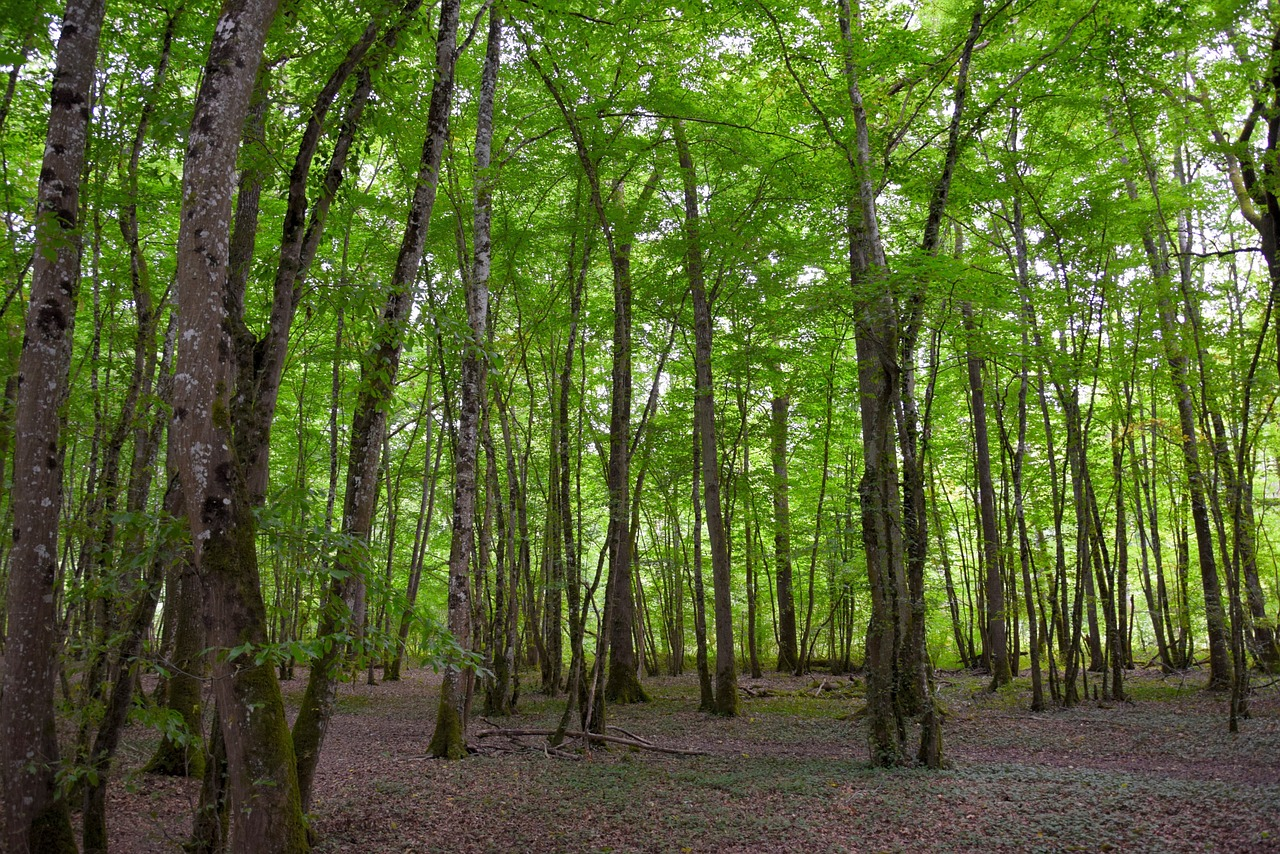

In [39]:
img = keras.utils.load_img("forest.jpg")

display(img)

bkg = image.img_to_array(img)

`composite` creates a new image based on a mask.  For each pixel in the new image:

- If the `mask` predicts the pixel to be in the background, we include the corresponding pixel from `background`.  
- If the `mask` predicts predicts the pixel to be in the foreground, we include the corresponding pixel from the `foreground`

We then display the `composite` of our prediction mask, `newarr`, the original photo, `arr`, and our forest image, `bkg`.

(697, 1215, 3)


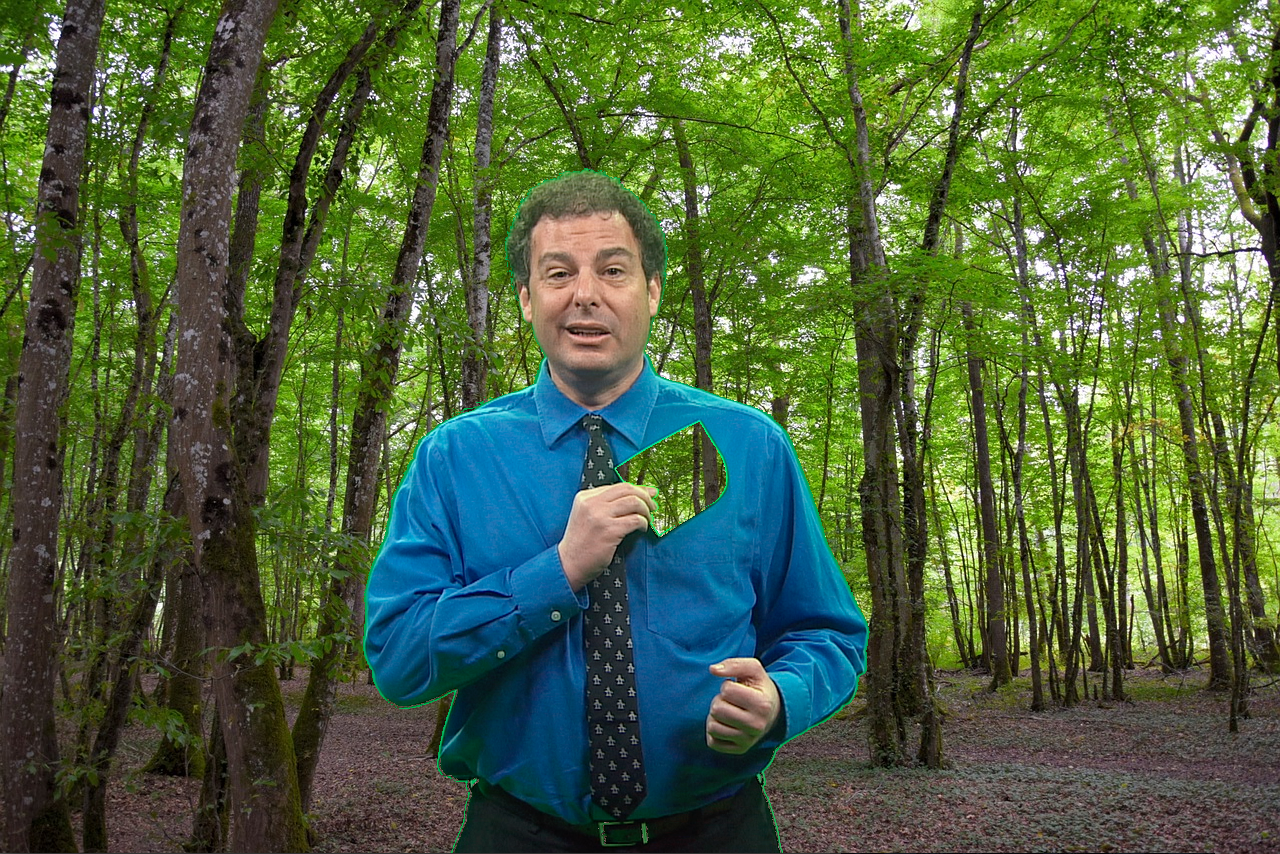

In [40]:
def composite(mask, foreground, background):
  ishift = 157
  print(mask.shape)
  for i in range(min(background.shape[0],foreground.shape[0]+ishift)):
    for j in range(min(background.shape[1], foreground.shape[1])):
      fgi = i - ishift
#      if not mask[i][j][0]: background[i][j] = foreground[i][j]
      if fgi >= 0 and not mask[fgi][j][0]: background[i][j] = foreground[fgi][j]
  display(image.array_to_img(background,scale=False))

composite(newarr,arr,bkg)